# Загрузка и предобработка данных

Укажем путь к папке, в которой хранятся данные и аннотации к изображениям

In [1]:
data_path = 'Webscope_I2/ydata-yshoes-image-content-v2_0'

Загрузим файл с MATLAB-массивом средствами библиотеки scipy и сохраним аннотации в dataframe

In [2]:
import scipy.io
import pandas as pd
import os

mat = scipy.io.loadmat(os.path.join(data_path, 'shoe_annos.mat'))
df_data = pd.DataFrame(mat['annotations'][0])

Посмотрим на несколько первых строк получившегося dataframe

In [3]:
df_data.loc[:5]

,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test
0,[classes/lowa_hiking/757550203_640.jpg],[[143]],[[55]],[[501]],[[417]],[[1]],[[0]]
1,[classes/lowa_hiking/769596630_640.jpg],[[136]],[[85]],[[505]],[[396]],[[1]],[[0]]
2,[classes/lowa_hiking/776409748_640.jpg],[[107]],[[91]],[[536]],[[392]],[[1]],[[0]]
3,[classes/lowa_hiking/854533006_640.jpg],[[261]],[[197]],[[380]],[[285]],[[1]],[[0]]
4,[classes/lowa_hiking/869234418_640.jpg],[[241]],[[182]],[[400]],[[299]],[[1]],[[0]]
5,[classes/lowa_hiking/863762462_640.jpg],[[259]],[[196]],[[383]],[[285]],[[1]],[[0]]


Колонка 'test' не используется, поэтому сразу удалим ее

In [4]:
df_data.drop('test', axis=1, inplace=True)

А поскольку MATLAB хранит данные в массивах, нужно извлечь из них значения в чистом виде

In [5]:
df_data = df_data.apply(lambda row: map(lambda x: x.item(), row), axis=1)

df_data.loc[:5]

,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,classes/lowa_hiking/757550203_640.jpg,143,55,501,417,1
1,classes/lowa_hiking/769596630_640.jpg,136,85,505,396,1
2,classes/lowa_hiking/776409748_640.jpg,107,91,536,392,1
3,classes/lowa_hiking/854533006_640.jpg,261,197,380,285,1
4,classes/lowa_hiking/869234418_640.jpg,241,182,400,299,1
5,classes/lowa_hiking/863762462_640.jpg,259,196,383,285,1


Сохраним получившийся dataframe в файл с расширением .csv

In [6]:
annos_file = os.path.join(data_path, 'shoes_annos.csv')

if not os.path.isfile(annos_file):
    df_data.to_csv(annos_file, index=False)

# Разметка суперклассов

Поскольку изображения имеют не только класс, но и суперкласс (как это показано в статье), а именно, всего 10 суперклассов, добавим такую колонку в нашу таблицу, заполнив ее нулями.

In [7]:
import numpy as np

df_data.insert(df_data.shape[1], 'superclass', np.zeros(df_data.shape[0], dtype=df_data['class'].dtype))

df_data.loc[:5]

,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,superclass
0,classes/lowa_hiking/757550203_640.jpg,143,55,501,417,1,0
1,classes/lowa_hiking/769596630_640.jpg,136,85,505,396,1,0
2,classes/lowa_hiking/776409748_640.jpg,107,91,536,392,1,0
3,classes/lowa_hiking/854533006_640.jpg,261,197,380,285,1,0
4,classes/lowa_hiking/869234418_640.jpg,241,182,400,299,1,0
5,classes/lowa_hiking/863762462_640.jpg,259,196,383,285,1,0


Перечислим названия всех суперклассов в списке. В статье на рис. 4 изображены только 9 из 10. Последний представитель был найден опытным путем перебором папок с классами -- это класс башмаков (clogs)

In [8]:
superclasses = ['high_heels', 'sandals', 'boots', 'boat_shoes', 'laced', 'flats', 'hiking', 'slipons', 'sneakers',
                'clogs']

Теперь расставим метки классов следующим образом: если название папки содержит одно из имен классов, ставим метку данного класса. Соответственно, метками будут числа от 1 до 10. Если же ни одно название класса не найдено в строке, ставим метку 0.

In [9]:
for row_ind, row in df_data.iterrows():
    
    for sc_index, sc_name in enumerate(superclasses):
        found_class = row['relative_im_path'].split('/')[1].find(sc_name)
        
        if found_class != -1:
            found_class = sc_index
            break
    
    df_data.loc[row_ind, 'superclass'] = found_class + 1

Проверим, есть ли неразмеченные объекты

In [10]:
not_labeled = df_data['superclass'] == 0

df_data[not_labeled][:5]

,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,superclass
1591,classes/reef_flip-flops/1137371400_640.jpg,241,207,400,274,32,0
1592,classes/reef_flip-flops/761340363_640.jpg,101,110,540,370,32,0
1593,classes/reef_flip-flops/917973253_640.jpg,85,127,556,354,32,0
1594,classes/reef_flip-flops/915226232_640.jpg,90,134,542,344,32,0
1595,classes/reef_flip-flops/815929123_640.jpg,101,120,540,360,32,0


Количество неразмеченных объектов равно:

In [11]:
df_data[not_labeled].shape[0]

249

Как мы видим, таких объектов 249, предположим, что все они имеют принадлежность к папке reef_flip-flops. Поскольку в этой папке именно 249 объектов, можно быть уверенным, что все эти объекты из одной папки. Обратившись к статье, узнаем, что эта обувь относится к суперклассу плоской обуви (flats)

In [12]:
flats_index = superclasses.index('flats') + 1

df_data['superclass'] = df_data['superclass'].apply(lambda row: flats_index if row == 0 else row)

df_data[df_data['superclass'] == 0]

,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,superclass


Теперь у нас не осталось неразмеченных объектов, поэтому можно сохранить dataframe с метками суперклассов в отдельный .csv-файл

In [13]:
annos_sc_file = os.path.join(data_path, 'shoes_annos_sc.csv')

if not os.path.isfile(annos_sc_file):
    df_data.to_csv(os.path.join(data_path, annos_sc_file), index=False)

И сохраним метки суперклассов в массиве

In [14]:
sc_labels_mapping = df_data[['class', 'superclass']] \
                    .drop_duplicates() \
                    .apply(lambda row: row['superclass'], axis=1) \
                    .values

# Извлечение признаков из изображений

В аннотации к изображениям также даны границы объектов, находящихся на изображении, убедимся в этом на примере

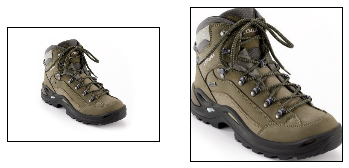

In [15]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

first_row = df_data.loc[0]

im = cv2.imread(os.path.join(data_path, first_row['relative_im_path']))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im_cut = im[first_row['bbox_y1']:first_row['bbox_y2'], first_row['bbox_x1']:first_row['bbox_x2'], :]

fig = plt.figure()

sp = fig.add_subplot(1, 2, 1)
sp.axes.get_xaxis().set_visible(False)
sp.axes.get_yaxis().set_visible(False)
sp.imshow(im)
sp.autoscale(False)

sp = fig.add_subplot(1, 2, 2)
sp.axes.get_xaxis().set_visible(False)
sp.axes.get_yaxis().set_visible(False)
sp.imshow(im_cut)
sp.autoscale(False)

Будем считывать изображения сразу в ч/б формате, обрезать их и вычислять дескрипторы SIFT

In [16]:
def compute_sift(df_data, data_path):
    sift = cv2.Feature2D_create('SIFT')
    sift_descs_list = []

    for _, row in df_data.iterrows():       
        im_path = os.path.join(data_path, row['relative_im_path'])
        im = cv2.imread(im_path, cv2.CV_LOAD_IMAGE_GRAYSCALE)
        im_cut = im[row['bbox_y1']:row['bbox_y2'], row['bbox_x1']:row['bbox_x2']]
        _, descs = sift.detectAndCompute(im_cut, None)
        sift_descs_list.append(descs)
        
    return sift_descs_list

Точек может оказываться слишком много, вычисления идти долго, поэтому можем пробовать брать некий процент от всех точек

In [17]:
def sample_points(descs_list, percentage, random_state=None):
    assert random_state is not None, 'Please specify random state to use algorithm'
    
    state = np.random.RandomState(random_state)
    
    def get_sample(points):
        n_points = points.shape[0]
        n_points_cons = int(round(percentage * n_points))
        indices_cons = state.permutation(n_points)[:n_points_cons]
        
        return points[indices_cons]
    
    return map(get_sample, descs_list)

Перейдем непосредственно к нахождению особых точек и вычислению SIFT, если они еще не были вычислены

In [18]:
sift_descs_file = os.path.join(data_path, 'sift_descs.npz')

if os.path.isfile(sift_descs_file):
    descs_dict = np.load(sift_descs_file).items()
    descs_dict_ord_by_int = map(lambda (k, v): (int(k.split('_')[1]), v), descs_dict)
    sift_descs_list = map(lambda (_, v): v, sorted(descs_dict_ord_by_int))
else:
    sift_descs_list = compute_sift(df_data, data_path)
    np.savez(sift_descs_file, *sift_descs_list)

И возьмем подмножество этих точек

In [19]:
percentage_points = 0.8
sift_sub_random_state = 42
sift_descs_list = sample_points(sift_descs_list, percentage_points, random_state=sift_sub_random_state)

Сохраним количество особых точек на каждое из изображений

In [20]:
kps_num = np.array(map(lambda x: x.shape[0], sift_descs_list))

И посчитаем среднее, чтобы оценить, какого размера будет строиться мешок слов

In [21]:
kps_num.mean()

197.51163306004875

Проставим индексы изображений: к какой картинке относится каждая из точек

In [22]:
image_labels = np.concatenate([ind * np.ones(kps_num_per_im, dtype=int)
                               for ind, kps_num_per_im in np.ndenumerate(kps_num)])

А теперь сложим дескрипторы в numpy-массив для удобства оперирования

In [23]:
sift_descs = np.vstack(sift_descs_list)

Кластеризуем особые точки

In [24]:
n_clusters = 200
cluster_labels_file_base_name = '_'.join(['cluster_labels', 'sift', str(percentage_points),
                                          str(sift_sub_random_state), str(n_clusters)]) + '.npy'
cluster_labels_file = os.path.join(data_path, cluster_labels_file_base_name)

if os.path.isfile(cluster_labels_file):
    cluster_labels = np.load(cluster_labels_file)
else:
    from sklearn.cluster import KMeans

    kmeans = KMeans(n_clusters=n_clusters, precompute_distances=True, n_init=1, n_jobs=-1)
    cluster_labels = kmeans.fit_predict(sift_descs)
    np.save(cluster_labels_file, cluster_labels)

Если изображение имеет $N$ особых точек, каждая из них попадает в мешок слов с весом $\frac{1}{N}$

In [25]:
weights = np.reciprocal(kps_num.astype(float))

Построим мешок слов

In [26]:
bag_of_words = np.zeros((len(sift_descs_list), n_clusters), dtype=float)

for point_ind, cluster_ind in np.ndenumerate(cluster_labels):
    label = image_labels[point_ind]
    bag_of_words[label, cluster_ind] += weights[label]

Извлечем метки классов

In [27]:
class_labels = df_data['class'].values
superclass_labels = df_data['superclass'].values
sc_labels_unique = np.unique(superclass_labels)

Посмотрим, как распределено количество объектов разных суперклассов

In [28]:
df_data['superclass'].value_counts()

2     1842
8      727
9      503
1      332
6      281
3      270
4      256
10     128
7       98
5       76
Name: superclass, dtype: int64

Определим вспомогательные функции взятия подмножества элементов, относящихся к определенным меткам классов

In [29]:
def get_subsample(arr, *labels):
    return np.hstack([np.argwhere(arr == label).flatten() for label in labels])

In [30]:
def get_sc_subsample(arr, *labels):
    arr_mapped = np.array(map(lambda label: sc_labels_mapping[label - 1], arr))
    return get_subsample(arr_mapped, *labels)

На основе имеющегося повторного train/test разбиения (KFold, ShuffleSplit) необходимо уметь брать подмножества элементов, относящихся к определенному суперклассу, поэтому определим вспомогательных класс для этого

In [31]:
class SplitSub(object):
    
    def __init__(self, arr, split, label, subsample_func):
        self.arr = arr
        self.split = split
        self.label = label
        self.subsample_func = subsample_func
        self.classes = np.unique(arr[subsample_func(arr, label)])
        self.iter_state = self.__iter__()
        
    def __iter__(self):
        for train, test in self._iter_indices():
            yield train, test
        
        return
    
    def next(self):
        return self.iter_state.next()
    
    def _iter_indices(self):
        for train, test in self.split:
            yield train[self.subsample_func(self.arr[train], self.label)], \
                  test[self.subsample_func(self.arr[test], self.label)]
                
    def __len__(self):
        return len(self.split)

Попробуем извлекать выходы последнего слоя, не являющегося полносвязным, который хорошо зарекомендовал себя в качестве описания изображения -- это 5ый pooling слой. Для этого определим файл deploy.custom.prototxt предобученной модели так: выбросим все слои, начиная с fc6, а также последний из всех оставшихся ReLU слоев.

In [32]:
import caffe

def caffe_image_transformer(shape, image_mean):
    image_mean = image_mean.transpose((1, 2, 0))
    im_height = shape[2]
    im_width = shape[3]
    image_mean = caffe.io.resize_image(image_mean, (im_height, im_width)).transpose((2, 0, 1))
    transformer = caffe.io.Transformer({'data': shape})
    transformer.set_transpose('data', (2, 0, 1)) # передвигаем канал трех цветов во внешнюю часть -- формат caffe 
    transformer.set_mean('data', image_mean)

    return transformer

def compute_cnn(df_data, data_path, caffe_dir, model_name, gpu_mode=False):
    net_dir = os.path.join(caffe_dir, 'models', model_name)
    net_def = os.path.join(net_dir, 'deploy.custom.prototxt')
    net_file_name = os.path.join(net_dir, model_name + '.caffemodel')
    net = caffe.Net(net_def, net_file_name, caffe.TEST)
    image_mean = np.load(os.path.join(caffe_dir, 'python', 'caffe', 'imagenet', 'ilsvrc_2012_mean.npy'))
    transformer = caffe_image_transformer(net.blobs['data'].data.shape, image_mean)
    caffe.set_mode_gpu() if gpu_mode else caffe.set_mode_cpu()
    cnn_descs_list = []

    for _, row in df_data.iterrows():       
        im_path = os.path.join(data_path, row['relative_im_path'])
        im = cv2.imread(im_path) # считывание изображения в BGR формате
        im_cut = im[row['bbox_y1']:row['bbox_y2'], row['bbox_x1']:row['bbox_x2']]
        net.blobs['data'].data[...] = transformer.preprocess('data', im)
        net.forward()
        cnn_features = net.blobs['pool5'].data[0]
        cnn_descs_list.append(np.mean(cnn_features, axis=(1, 2)))
        
    return np.vstack(cnn_descs_list)

И попробуем извлекать признаки из сети vgg-16

In [33]:
model_name = 'VGG_ILSVRC_16_layers'
cnn_descs_file = os.path.join(data_path, 'cnn_descs_' + model_name + '.npy')

if os.path.isfile(cnn_descs_file):
    cnn_descs = np.load(cnn_descs_file)
else:
    caffe_dir = os.path.join(os.getenv('HOME'), 'libraries', 'caffe')
    cnn_descs = compute_cnn(df_data, data_path, caffe_dir, model_name, gpu_mode=True)
    np.save(cnn_descs_file, cnn_descs)

# Обучение классификаторов

Иерархическая классификация. Для классификаторов, работающих с более чем двумя классами, вручную выставим шкалу параметра регуляризации

In [34]:
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import KFold
from sklearn.svm import SVC
import warnings

def learn_hierarchy_clfs(img_descs):
    warnings.filterwarnings('ignore')
    clfs_h_num = sc_labels_unique.size + 1
    clfs_h = map(lambda _: SVC(kernel='linear', decision_function_shape='ovo', class_weight='balanced'),
                 xrange(clfs_h_num))
    kfold = KFold(class_labels.size, n_folds=4, shuffle=True, random_state=42)
    
    par_h = map(lambda _: {'C': scipy.stats.expon(scale=25)}, xrange(clfs_h_num))
    par_h[0] = {'C': scipy.stats.expon(scale=5000)}
    par_h[1] = {'C': scipy.stats.expon(scale=15)}
    par_h[2] = {'C': scipy.stats.expon(scale=10)}
    par_h[3] = {'C': scipy.stats.expon(scale=30)}
    par_h[8] = {'C': scipy.stats.expon(scale=100)}
    par_h[9] = {'C': scipy.stats.expon(scale=100)}
    
    scoring = 'accuracy'   
    rs_h = [RandomizedSearchCV(clfs_h[0], n_iter=12, param_distributions=par_h[0], scoring=scoring, cv=kfold,
                               n_jobs=-1)]
    rs_h[0].fit(img_descs, superclass_labels)

    print 'Superclass labels size = {0}, score = {1}'.format(sc_labels_unique.size, rs_h[0].best_score_)

    for sc_label in sc_labels_unique:
        kfold_sub = SplitSub(class_labels, kfold, sc_label, get_sc_subsample)
        rs_h.append(RandomizedSearchCV(clfs_h[sc_label], n_iter=12, param_distributions=par_h[sc_label],
                                       scoring=scoring, cv=kfold_sub, n_jobs=-1))
        rs_h[sc_label].fit(img_descs, class_labels)

        print 'Class labels size = {0}, score = {1}'.format(kfold_sub.classes.size, rs_h[sc_label].best_score_)
        
    warnings.resetwarnings()
    
    return rs_h

Результат работы на мешке слов дескрипторов SIFT

In [35]:
rs_h_bow = learn_hierarchy_clfs(bag_of_words)

Superclass labels size = 10, score = 0.442277863949
Class labels size = 7, score = 0.436746987952
Class labels size = 29, score = 0.325732899023
Class labels size = 6, score = 0.696296296296
Class labels size = 2, score = 0.80859375
Class labels size = 2, score = 0.828947368421
Class labels size = 2, score = 0.918149466192
Class labels size = 2, score = 0.857142857143
Class labels size = 10, score = 0.423658872077
Class labels size = 8, score = 0.544731610338
Class labels size = 2, score = 0.84375


Теперь то же самое, но на нейронных дескрипторах

In [36]:
rs_h_cnn = learn_hierarchy_clfs(cnn_descs)

Superclass labels size = 10, score = 0.881010414359
Class labels size = 7, score = 0.843373493976
Class labels size = 29, score = 0.681324647123
Class labels size = 6, score = 0.825925925926
Class labels size = 2, score = 0.91015625
Class labels size = 2, score = 0.921052631579
Class labels size = 2, score = 0.996441281139
Class labels size = 2, score = 0.897959183673
Class labels size = 10, score = 0.756533700138
Class labels size = 8, score = 0.850894632207
Class labels size = 2, score = 0.9375


Нейронные коды проявили себя лучше, поэтому попытаемся использовать выходы SVМ, построенные на их основе. К слову, попытки построить описание на основе выходов линейных SVM, классифицирующих мешок слов, увенчались тем, что нелинейный SVM на таких описаниях выдавал оценку качества в районе 0.3-0.4. Также были попытки построить случайный лес и градиентный бустинг на мешке слов, результаты оказывались приблизительно такими же. Возможно, для получения высоких результатов требуется увеличить в несколько раз размерность мешка, чего в моем случае не позволяют вычислительные ресурсы.

In [37]:
clfs_h_best = map(lambda rs: rs.best_estimator_, rs_h_cnn)

Конкатенация выходов decision_function 11-ти линейных SVM

In [38]:
def decision_function(clfs_h, X):
    dec = map(lambda x: np.reshape(x, (x.size, 1)) if x.ndim == 1 else x,
              [clf_h.decision_function(X) for clf_h in clfs_h])
    
    return np.hstack(dec)

Описание изображения на основе выходов SVM по схеме KFold: тренируемся на $N-1$ блоке, на оставшемся предсказываем, так $N$ раз

In [39]:
def kfold_decision(clfs_h, X, superclass_labels, class_labels, kfold):
    test_indices = []
    dec = []
    
    for train, test in kfold:
        test_indices.append(test)
        clfs_h[0].fit(X[train], superclass_labels[train])
        
        for sc_label in sc_labels_unique:
            train_sub = train[get_sc_subsample(class_labels[train], sc_label)]
            clfs_h[sc_label].fit(X[train_sub], class_labels[train_sub])
            
        dec.append(decision_function(clfs_h, X[test]))
        
    inv_indices = np.argsort(np.concatenate(test_indices), kind='mergesort')
    
    return np.vstack(dec)[inv_indices]

Вычислим описания нейронные коды -> выходы SVM

In [40]:
dec_cnn = kfold_decision(clfs_h_best, cnn_descs, superclass_labels, class_labels,
                         KFold(class_labels.size, n_folds=10, shuffle=True, random_state=42))

Определим 5-итерационное разбиение на train/test части

In [41]:
from sklearn.cross_validation import ShuffleSplit

split = ShuffleSplit(class_labels.size, n_iter=5, test_size=0.1, random_state=42)

И попробуем применять эти выходы в качестве признаков для нелинейного SVM. Предварительные запуски дали понять, что ядро RBF показывает себя не очень здорово, поэтому при подборе параметров будем пробовать только полиномиальные пространство признаков

In [42]:
from sklearn.grid_search import GridSearchCV

svc = SVC(decision_function_shape='ovr')
par_svc = {'kernel': ['poly'],
           'degree': np.arange(2, 5),
           'C': np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]),
           'gamma': np.array([0.1, 0.5, 1, 5]),
           'class_weight': [None, 'balanced']}
gs_svc = GridSearchCV(svc, par_svc, scoring='accuracy', cv=split, n_jobs=-1)
gs_svc.fit(dec_cnn, class_labels)

print gs_svc.best_score_

0.668584070796


Получилась достойная модель, которая превосходит результат статьи на 2.2%

In [43]:
best_ind_svc = np.argmax(np.array(map(lambda score: tuple(score)[1], gs_svc.grid_scores_)))
print 'Оценки на shuffle-split: {0}\nСведения: {1}'.format(gs_svc.grid_scores_[best_ind_svc].cv_validation_scores,
                                                           gs_svc.grid_scores_[best_ind_svc])

Оценки на shuffle-split: [ 0.66814159  0.63938053  0.68362832  0.67920354  0.67256637]
Сведения: mean: 0.66858, std: 0.01554, params: {'kernel': 'poly', 'C': 0.01, 'gamma': 0.5, 'degree': 2, 'class_weight': None}


А теперь попробуем построить модель на основе градиентного бустинга. Для начала понизим размерность признакового описания, чтобы повысить эффективность построения деревьев. Градиентный бустинг зарекомендовал себя, поскольку показывает высокое качество, при этом имеет свойство не переобучаться при увеличении количества используемых в нем классификаторов даже до нескольких тысяч.

In [44]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, whiten=True)
cnn_descs_pca = pca.fit_transform(cnn_descs)

print '# компонент = {0}, доля объясненной дисперсии = {1}'.format(pca.n_components_,
                                                                   pca.explained_variance_ratio_.sum())

# компонент = 91, доля объясненной дисперсии = 0.950544416904


In [45]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=500, subsample=0.8, colsample_bytree=0.5)
par_xgb = {'max_depth': np.arange(4, 7),
           'min_child_weight': np.arange(1, 4)}
gs_xgb = GridSearchCV(xgb, par_xgb, scoring='accuracy', cv=split)
gs_xgb.fit(cnn_descs_pca, class_labels)

print gs_xgb.best_score_

0.693805309735


In [46]:
best_ind_xgb = np.argmax(np.array(map(lambda score: tuple(score)[1], gs_xgb.grid_scores_)))
print 'Оценки на shuffle-split: {0}\nСведения: {1}'.format(gs_xgb.grid_scores_[best_ind_xgb].cv_validation_scores,
                                                           gs_xgb.grid_scores_[best_ind_xgb])

Оценки на shuffle-split: [ 0.71017699  0.68584071  0.69026549  0.6880531   0.69469027]
Сведения: mean: 0.69381, std: 0.00869, params: {'max_depth': 4, 'min_child_weight': 1}


Полученный алгоритм превосходит тот, что предложен в статье, на 4.7%